# Pour débuter

La librairie `libs` contient le code correspondant au mémoire *Extraction de taxonomie par regroupement hiérarchique de plongements vectoriels de graphes de connaissances* (accessible ici : [papers/memoire.pdf](papers/memoire.pdf)). On présente ici un aperçu de ses principales classes et fonctions.

**Contenu**

- [Graphes de connaissance](#Graphes-de-connaissance)
    - [Lecture et sauvegarde d'un graphe](#1.-Lecture-et-sauvegarde-d'un-graphe)
    - [Manipulations de base](#2.-Manipulations-basiques)
- [Modèles de plongement](#Modèles-de-plongement)
- [Taxonomie](#Taxonomie)
    - [Généralités sur les arbres](#1.-Généralités-sur-les-arbres)
    - [Manipulation de taxonomies](#2.-Manipulation-de-taxonomies)
- [Extraction non-expressive](#Extraction-non-expressive)
    - [Données](#1.-Données)
    - [Extraction](#2.-Extraction)
    - [Évaluation](#3.-Évaluation)
- [Extraction expressive](#Extraction-expressive)

## Graphes de connaissance

Avant d'appliquer un modèle de plongement ou un algorithme d'extraction taxonomique, il nous faut un graphe de connaissance $\mathcal{KG} \subseteq \mathcal{E \times R \times E}$. $\mathcal{E}$ et $\mathcal{R}$ représentent, respectivement, l'ensemble des entités et l'ensemble des relations du graphe.

Pour représenter et manipuler un tel graphe, on utilise la classe `libs.graph.KnowledgeGraph`.

### 1. Lecture et sauvegarde d'un graphe

Pour lire un graphe de connaissance au format RDF/TTL, on peut utiliser la méthode `build_from_ttl`. Dans l'exemple suivant, on télécharge le fichier TTL contenant les triplets de DB15K, puis on le lit.

In [7]:
import requests
import os

from libs.graph import KnowledgeGraph

# 1 : Si les données sont absentes, on les télécharge
if not os.path.exists("db15k.ttl"):
    r = requests.get("https://raw.githubusercontent.com/nle-ml/mmkb/master/DB15K/DB15K_EntityTriples.txt")
    with open("db15k.ttl", "wb") as f:
        f.write(r.content)
    
# 2 : Lecture du graphe à partir du fichier TTL. shorten=True raccourcit automatiquement les URI avec des préfixes connus
kg = KnowledgeGraph.build_from_ttl("db15k.ttl", shorten=True)

print(f"Graph has {len(kg)} triples, {len(kg.ent)} entities and {len(kg.rel)} relations.")

Graph has 99028 triples, 12842 entities and 279 relations.


Toutefois, il est préférable de stocker les graphes au format [OpenKE](http://openke.thunlp.org/static/notes/data.html). Dans le format OpenKE, chaque entité est associée à un identifiant entier compris entre $0$ et $|\mathcal{E}|-1$, et chaque relation est associée à un identifiant entier compris entre $0$ et $|\mathcal{R}|-1$. Le format OpenKE consiste en cinq fichiers :

- `ent2id.txt` et `rel2id.txt` stockent les URI et les identifiants des entités et des relations, respectivement. La première ligne du fichier indique le nombre d'éléments contenus dans le fichier (c'est-à-dire $|\mathcal{E}$ et $\mathcal{R}|$, respectivement); chacune des lignes suivantes contient une URI et son identifiant, séparés par une espace.

- `test2id.txt`, `train2id.txt`, `val2id.txt` contiennent les triplets du graphe. La première ligne indique le nombre de triplets du fichier. Chaque ligne contient un triplet $(h, t, r)$ (attention à l'ordre !) dont les éléments sont représentés par leurs identifiants et séparés par une espace.

Pour stocker notre graphe de connaissance dans ce format, on dispose de la méthode `to_dir`, qui prend comme argument le chemin du dossier dans lequel on souhaite stocker le graphe. Une fois le graphe sauvegardé, on peut lui donner un nom et l'**enregistrer** avec la méthode `register`. Cela permet ensuite de le charger plus facilement.

In [11]:
kg.to_dir("data/graph/db15k")
kg.register("db15k")

Ici, on a enregistré le graphe sous le nom `"db15k"`. Par la suite, on pourra le charger avec la commande `from_dir`, simplement en donnant ce nom.

In [12]:
del kg

kg = KnowledgeGraph.from_dir("db15k")

Triples: 100%|███████████████████████████████████████████████████████████████| 89197/89197 [00:00<00:00, 113786.40it/s]


On peut enregistrer un graphe à la main, en l'ajoutant au fichier `resources.json`. On peut également passer à la méthode `from_dir` le chemin vers un dossier contenant un graphe, sans que celui-ci soit enregistré.

⚠️ Le *parser* utilisé pour lire les fichiers TTL est assez basique. Si votre graphe n'est pas au format TTL ou résiste à `build_from_ttl`, utilisez une librairie dédiée comme [`rdflib`](https://pypi.org/project/rdflib/) et créez le graphe avec la méthode `from_triples`. Voici un exemple :

In [24]:
from rdflib import Graph

g = Graph()
g.parse("http://bigasterisk.com/foaf.rdf")
triples = [(str(h), str(r), str(t)) for h, r, t in g]
kg = KnowledgeGraph.from_triples(triples)

print(f"Graph has {len(kg)} triples, {len(kg.ent)} entities and {len(kg.rel)} relations.")

Graph has 62 triples, 55 entities and 35 relations.


### 2. Manipulations basiques


Dans la suite, on utilise le graphe «jouet» fourni avec la librairie. C'est un sous-ensemble restreint de DBpédia, contenant environ 300 000 triplets, qui peut être chargé avec la commande suivante :

In [32]:
kg = KnowledgeGraph.from_dir("toy")

Triples: 100%|██████████████████████████████████████████████████████████████| 316114/316114 [00:03<00:00, 91951.97it/s]


Un graphe est constitué d'un ensemble d'entités `kg.ent` et d'un ensemble de relations `kg.rel`, reliées entre elles. Pour passer de l'URI à l'identifiant et inversement, on utilise `to_id` et `to_name`. `kg.ent` et `kg.rel` supportent les tests d'appartenance avec le mot-clé `in`.

In [34]:
print("dbr:United_States" in kg.ent)
print("dbr:United_States <-->", kg.ent.to_id("dbr:United_States"))
print(kg.rel.to_name(0), "<--> 0")

True
dbr:United_States <--> 74
dbo:team <--> 0


Pour rechercher des triplets dans le graphe, on utilise la méthode `find_triples`. Elle prend trois arguments optionnels qui sont `h`, `r` et `t`, correspondant respectivement au sujet, à la relation et à l'objet du triplet à rechercher; ces trois arguments peuvent prendre indifférement des URI ou des identifiants. Par défaut, les triplets sont retournés au format identifiant, mais on peut renvoyer des strings en choisissant `as_string=True`. On peut choisir de limiter le nombre de résultats avec `max_results`.

In [22]:
kg.find_triples(h="dbr:Seven_Years'_War", r="dbo:commander", as_string=True, max_results=10)

[("dbr:Seven_Years'_War", 'dbo:commander', 'dbr:Charles,_Prince_of_Soubise'),
 ("dbr:Seven_Years'_War", 'dbo:commander', 'dbr:Frederick_the_Great'),
 ("dbr:Seven_Years'_War",
  'dbo:commander',
  'dbr:Pedro_Pablo_Abarca_de_Bolea,_10th_Count_of_Aranda'),
 ("dbr:Seven_Years'_War", 'dbo:commander', 'dbr:Louis_XV_of_France'),
 ("dbr:Seven_Years'_War",
  'dbo:commander',
  'dbr:Duke_Ferdinand_of_Brunswick-Wolfenbüttel'),
 ("dbr:Seven_Years'_War", 'dbo:commander', 'dbr:Robert_Clive'),
 ("dbr:Seven_Years'_War",
  'dbo:commander',
  'dbr:Jeffery_Amherst,_1st_Baron_Amherst'),
 ("dbr:Seven_Years'_War", 'dbo:commander', 'dbr:Alexander_Buturlin'),
 ("dbr:Seven_Years'_War", 'dbo:commander', 'dbr:Pedro_Antonio_de_Cevallos'),
 ("dbr:Seven_Years'_War",
  'dbo:commander',
  'dbr:Prince_Henry_of_Prussia_(1726–1802)')]

Plutôt que de renvoyer les triplets complets, on peut choisir d'obtenir uniquement les sujets, les objets ou les relations avec respectivement `heads()`, `tails()` et `relations()`, qui ont la même signature que `find_triples`.

Par exemple, on peut afficher l'ensemble des personnes nées au Québec avec :

In [3]:
kg.heads(r="dbo:birthPlace", t="dbr:Quebec", as_string=True)

['dbr:Dalia_Shusterman',
 'dbr:Roméo_Beaudry',
 'dbr:Francis_Lessard',
 'dbr:Carol_Vadnais',
 'dbr:Gilles_Ste-Croix',
 'dbr:Pat_Burns',
 'dbr:Marlene_Jennings',
 'dbr:Melissa_Altro',
 'dbr:CFCF_(musician)',
 'dbr:Albert_Gervais',
 'dbr:Lorraine_Desmarais',
 'dbr:Robert_MacNeil',
 'dbr:Stéfanie_Tremblay']

Ou l'ensemble des liens qui unissent Baltacı à l'Empire ottoman :

In [16]:
kg.relations(h="dbr:Baltacı_Mehmet_Pasha", t="dbr:Ottoman_Empire", as_string=True)

['dbo:birthPlace', 'dbo:deathPlace', 'dbo:country', 'dbo:nationality']

Pour explorer facilement le voisinage d'une entité, on utilisera la méthode `print_relations()`. Par défaut, elle affiche toutes les relations dont l'entité choisie est sujet ou objet. Ce comportement peut être changé avec `inverse=False`.

In [5]:
kg.print_relations("dbr:Leon_Trotsky")

dbr:Leon_Trotsky
	 rdf:type
		 dbo:Agent
		 dbo:Person
		 dbo:OfficeHolder
	 is dbo:commander of
		 dbr:Polish–Soviet_War
		 dbr:July_Days
		 dbr:Eastern_Front_of_the_Russian_Civil_War
		 dbr:Russian_Revolution


⚠️ Un graphe de connaissance peut consommer beaucoup de mémoire. La version complète de DBpédia demande environ 20 Go de RAM, et encore, en utilisant `lightweight=True` lors de sa lecture (ce qui permet d'ignorer les relations `rdfs:label`, `foaf:name` et `dcterms:description` ainsi que les types extérieurs comme `yago:WikiCat` : ces données sont inutiles pour beaucoup d'usages et coûtent cher en mémoire). La lecture de ce graphe depuis le disque demande entre sept et neuf minutes. À noter que, dans mes essais, l'implémentation de `rdflib` était encore plus inefficace.

## Modèles de plongement

Pour entraîner les modèles de plongement, j'ai eu recours à [OpenKE](https://github.com/thunlp/OpenKE) (d'où le choix de ce format pour stocker les graphes). Toutefois, depuis cette époque, de nouvelles librairies sont sorties, qui sont potentiellement plus efficaces. Voir par exemple [TorchKGE](https://pypi.org/project/torchkge/).

Pour ce projet, il est attendu que les plongements soient représentés par une matrice de dimension $n \times d$ avec $n = |\mathcal{E}|$ et $d$ la dimension des plongements, elle-même stockée dans un array numpy au format `.npy`. On peut ainsi la charger avec `numpy.load()`.

Comme les graphes de connaissance, les modèles de plongement peuvent être ajoutés au fichier `resources.json`, ce qui permet de les charger plus facilement. On peut également fournir un modèle par défaut avec la clé `"default"`. Par défaut, on dispose d'un modèle TransE de dimension 50 entraîné sur le graphe «jouet».

In [7]:
from libs import embeddings

E = embeddings.load("toy")
E.shape

(54795, 50)

## Taxonomie

Une taxonomie $T$ est un arbre orienté dont les arêtes représentent des relations de subsomption. Elle est représentée par la classe `libs.taxonomy.Taxonomy`, qui hérite de `libs.tree.Node`, la classe générique qui nous sert à représenter les arbres. Commençons par présenter cette première classe, qui sert aussi à représenter les arbres de clustering.

### 1. Généralités sur les arbres

On identifie un arbre est représenté par la classe `Node`. Essentiellement, un arbre `A` est constitué d'un identifiant `A.id`, et de sous-arbres (stockés dans `A.children`). Si `A.children` est vide, alors `A` est une feuille. `A` contient également un pointeur vers son parent immédiat `A.parent`, qui vaut `None` si `A` n'a pas de parent (*i.e.* `A` est une racine de l'arbre). Autrement dit, on identifie «nœud $A$» et «sous-arbre ayant $A$ pour racine» (noté $X[A]$ dans mon mémoire).

Un nœud possède également un nom `A.name`, qui par défaut est égal à `str(A.id)`. N'importe quel objet *hashable* peut servir d'identifiant.

**Manipulations basiques**

In [1]:
from libs.tree import Node

A = Node("A")

# Ajout d'enfants
A.add_many(["B", "C", "D"])
A.print()

# Retrait d'un enfant
A.remove("D")
A.print()

  ┌B
 A┤
  ├D
  └C
  ┌B
 A┤
  └C


On peut accéder à un nœud d'un arbre à l'aide de son identifiant, en utilisant la notation crochets :

In [2]:
B = A["B"]
B.add_many(["B1", "B2", "B3", "B4"])
B["B3"].add("B31")

A.print()
B.print()

  ┌C
 A┤
  │ ┌B1
  │ ├B2
  └B┤
    ├B3┐
    │  └B31
    └B4
  ┌B1
  ├B2
 B┤
  ├B3┐
  │  └B31
  └B4


Un nœud expose les attributs `is_leaf`, `is_root`, `n_children` et `siblings`.

In [3]:
for node in ["A", "B", "B4", "B31"]:
    node = A[node]
    print(node, " : ",
          "root=", node.is_root, 
          ", leaf=", node.is_leaf, 
          ", nb of children=", node.n_children, 
          ", siblings=", *node.siblings(),
          sep="",
    )

A : root=True, leaf=False, nb of children=2, siblings=
B : root=False, leaf=False, nb of children=4, siblings=C
B4 : root=False, leaf=True, nb of children=0, siblings=B1B2B3
B31 : root=False, leaf=True, nb of children=0, siblings=


On peut tester si un nœud est un descendant d'un autre nœud avec `<` :

In [4]:
C = A["B31"]
C < B < A

True

**Parcours**

Un arbre est itérable. L'itération se fait sur tous les nœuds de l'arbre, racine comprise. Si l'on souhaite exclure la racine, on peut utiliser `iter_children()` (le nom est ambigu, car `Node.iter_children()` est différent de `iter(Node.children)`. Un nom plus approprié serait `iter_successors`). L'itération a lieu sans garantie sur l'ordre.

In [5]:
print("Root included:", *(node for node in A))
print("Root excluded:", *A.iter_children())

Root included: A B C B1 B2 B3 B4 B31
Root excluded: B C B1 B2 B3 B4 B31


On peut également effectuer un parcours en largeur (BFS, pour *Breadth First Search*) et un parcours en profondeur (DFS, pour *Depth First Search*) de l'arbre avec les méthodes `Node.bfs()` et `Node.dfs()`. Dans les deux cas, on peut spécifier une profondeur maximale de recherche avec `max_depth`, un nombre maximal de nœuds avec `max_nodes`, et enfin une condition d'arrêt personnalisée avec `halting_func` (qui prend un nœud en entrée et retourne un booléen).

In [6]:
print("DFS:", *A.dfs())
print("BFS:", *A.bfs())

DFS: A C B B4 B3 B31 B2 B1
BFS: A B C B1 B2 B3 B4 B31


**Création, lecture, écriture**

On peut créer et modifier un arbre avec les méthodes `add`, `add_many`, `remove`, `remove_many` présentées plus haut. Un autre moyen, souvent plus efficace, pour créer un arbre, consiste à fournir la liste de ses arêtes. Par exemple :

In [7]:
edges = [
    ("c1", "b1"),
    ("c2", "b1"),
    ("b1", "a1"),
    ("b2", "a2"),
    ("b3", "a3"),
    ("a1", "root"),
    ("a2", "root"),
    ("a3", "root")
]

tree = Node.from_edges(edges)
tree.print()

     ┌a2┐
     │  └b2
     ├a3┐
     │  └b3
 root┤
     └a1┐
        │  ┌c1
        └b1┤
           └c2


Inversement, on peut obtenir la liste des arêtes à partir d'un arbre, avec la méthode `Node.to_edges()`. On peut également sauvegarder un arbre dans un fichier avec `Node.to_file()` and `Node.from_file()`. Dans les deux cas, un fonction `preprocess` peut être appelée pour transformer un identifiant en chaîne de caractère, ou une chaîne de caractère en identifiant, ce qui permet de stocker des nœuds non-textuels avec des méthodes de sérialisation/désérialisation.

Prenons l'exemple d'un arbre dont les nœuds sont des entiers.

In [8]:
tree = Node.from_edges([(4, 1), (5, 1), (1, 0), (2, 0), (3, 0)])
tree.print()
print(type(tree.id))

tree.to_file("dummy_tree.txt")

  ┌2
  ├3
 0┤
  │ ┌4
  └1┤
    └5
<class 'int'>


In [9]:
# Sans désérialisation
tree2 = Node.from_file("dummy_tree.txt")
print(type(tree2.id)) # str au lieu de int

# Avec désérialisation
tree3 = Node.from_file("dummy_tree.txt", preprocess=int)
print(type(tree3.id)) # int, comme prévu

<class 'str'>
<class 'int'>


**Manipulations d'arbres**

On peut détacher un sous-arbre d'un arbre existant avec `Node.detach()`, attacher deux arbres ensembles avec `Node.attach()` et `Node.move()` pour déplacer un sous-arbre.

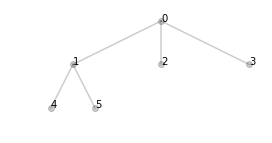

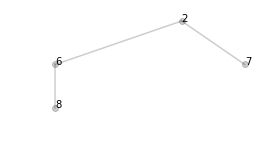

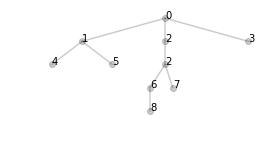

In [18]:
params = dict(figure_params=dict(figsize=(4, 2)))
tree = Node.from_edges([(4, 1), (5, 1), (1, 0), (2, 0), (3, 0)])
tree.plot(**params)

other = Node.from_edges([(8, 6), (6, 2), (7, 2)])
other.plot(**params)
other.attach(tree[2])

tree.plot(**params)

### 2. Manipulation de taxonomies

`libs.taxonomy.Taxonomy` reprend tous les principes précédents (avec `from_axioms` et `to_axioms` à la place de `from_edges` et `to_edges`) et ajoute quelques attributs supplémentaires comme `Taxonomy.hierarchy` (pour afficher toutes les superclasses d'une classe donnée).

Pour créer une taxonomie à partir d'une ontologie `OWL`, il suffit de récupérer les liens `rdfs:subClassOf`, comme dans l'exemple suivant :

In [22]:
import rdflib
import requests
from rdflib import Graph

from libs.taxonomy import Taxonomy
from libs.graph import KnowledgeGraph
from libs.graph.uri import shorten

# On récupère l'URL de la taxonomie DBpédia sur la page : https://databus.dbpedia.org/denis/ontology/dbo-snapshots/
DBO_URL = "https://raw.githubusercontent.com/dbpedia/ontology-tracker/7157d38fbde8b942e9807e722586d593f4d31451/databus/dbpedia/ontology/dbo-snapshots/dbo-snapshots.ttl"
g = Graph()
g.parse(DBO_URL, format="ttl")

# shorten sert à raccourcir les URI avec des préfixes connus
triples = [(shorten(str(h)), shorten(str(r)), shorten(str(t))) for h, r, t in g]
dbo = KnowledgeGraph.from_triples(triples)
axioms = [(h, t) for h, _, t in dbo.find_triples(r="rdfs:subClassOf", as_string=True)]

# Création de la taxonomie
T = Taxonomy.from_edges(axioms, add_root="__root__")

print(T.summary())

[('dbo:ReligiousBuilding', 'dbo:Building'), ('dbo:Ship', 'schema:Product'), ('dbo:Ship', 'dbo:MeanOfTransportation'), ('dbo:Locality', 'dbo:PopulatedPlace'), ('dbo:Entomologist', 'dbo:Scientist'), ('dbo:PopulatedPlace', 'dbo:Place'), ('dbo:Instrument', 'dbo:Device'), ('dbo:Instrument', 'schema:Product'), ('dbo:Lighthouse', 'dbo:Tower'), ('dbo:Blazon', 'owl:Thing')]
785 classes
Level 0: __root__
Level 1: schema:MusicRecording, http://www.ontologydesignpatterns.org/ont/dul/DUL.owl#SocialPerson, schema:Festival, http://www.ontologydesignpatterns.org/ont/dul/DUL.owl#InformationObject, http://www.ontologydesignpatterns.org/ont/dul/DUL.owl#Event and 11 others
...
Level 7: dbo:SubMunicipality, dbo:Prefecture, dbo:Canton, dbo:Province, dbo:Arrondissement and 16 others
Level 8: dbo:HistoricalDistrict, dbo:HistoricalProvince, dbo:OverseasDepartment, dbo:FormerMunicipality


## Extraction non-expressive


### 1. Données


L'extraction non-expressive nécessite un jeu d'entraînement $\mathcal{D} \subseteq \mathbb{R}^d \times \mathcal{T}$, constitué de plongements vectoriels typés. Ce jeu d'entraînement est représenté par la classe `libs.dataset.Dataset`. Trois fonctions peuvent aider à en créer un :
- `create_from_classes`: prend en entrée la liste de classes $\mathcal{T}$ (ou *types*) qui doivent figurer dans les données. Des instances de chaque classe sont prélevées aléatoirement dans le graphe pour constituer les données.
- `create_from_instances`: prend en entrée une liste d'entités (représentées par leurs identifiants). Un de leur type est choisi aléatoirement comme label.
- `create_from_typed_instances` : fonction auxiliaire qui prend en entrée une liste d'entités et une liste de types.

Dans les deux premiers cas, la création d'un `Dataset` suppose d'avoir accès à un graphe de connaissance : soit pour trouver des instances d'une classe donnée, soit pour trouver la classe d'une entité donnée.

In [1]:
from libs.graph import KnowledgeGraph

kg = KnowledgeGraph.from_dir("toy")
len(kg)

Triples: 100%|██████████████████████████████████████████████████████████████| 316114/316114 [00:03<00:00, 98671.47it/s]


316114

Voici trois exemples de création de `Dataset` :
- 1 000 instances de chacune des classes `Organisation`, `Person`, `Event`, `Place`
- Mêmes classes, mais nombre d'instances variable
- Création d'un dataset contenant uniquement des personnes nées aux États-Unis

In [8]:
import libs.dataset as data
from libs.dataset import Dataset

# Création à partir des classes
df1 = data.create_from_classes(kg, classes=["dbo:Organisation", "dbo:Person", "dbo:Event", "dbo:Place"], class_size=1000)
print(df1.summary())

df2 = data.create_from_classes(kg, 
                               classes=["dbo:Organisation", "dbo:Person", "dbo:Event", "dbo:Place"],
                              class_size=[300, 300, 500, 1000])
print(df2.summary())

# Création à partir des instances
df3 = data.create_from_instances(kg, instances=kg.heads(r="dbo:birthPlace", t="dbr:United_States"))
print(df3.summary())

Dataset (4 classes, 4000 instances):
---
dbo:Organisation   1000
dbo:Person         1000
dbo:Event          1000
dbo:Place          1000
...
Dataset (4 classes, 2100 instances):
---
dbo:Place          1000
dbo:Event          500
dbo:Organisation   300
dbo:Person         300
...
Dataset (18 classes, 78 instances):
---
dbo:Person              29
dbo:Agent               22
dbo:OfficeHolder        5
dbo:Athlete             4
dbo:IceHockeyPlayer     2
...


Comment déterminer le nombre d'instances à prélever pour chaque classe ?

Supposons qu'il y ait $N_{unique}$ types distincts, que le cumul des effectifs de chaque classe soit noté $N_{total}$, et que l'on cherche à prélever $N_{target}$ échantillons au total. Pour déterminer le nombre d'entités à prélever pour un type donné ayant $m$ éléments, on peut imaginer trois stratégies :

- Même nombre d'éléments pour chaque classe : $N_{unif} = \frac{N_{unique}}{N_{target}}$

- Nombre d'éléments proportionnel à l'effectif réel de la classe : $N_{prop} = m \cdot \frac{N_{target}}{N_{total}}$

- Mélange des deux précédents : $N_{mix} = \alpha N_{unif} + (1 - \alpha) N_{prop}$ avec $\alpha \in [0, 1]$ un paramètre

Dans la stratégie uniforme, toutes les classes ont le même effectif, ce qui biaise les données vers les classes rares. Dans la stratégie proportionnelle, étant donnés les déséquilibres entre effectifs (en gros : 1,5M d'agents, 1,3M de personnes, 800k lieux, 300k athlètes, donc rapidement des différences de plusieurs ordres de grandeur), on a un gros biais vers les classes fréquentes. On peut affiner avec un sampling log-proportionnel, ou mieux avec un mélange linéaire/log-proportionnel.

Voir le notebook `08_Subtaxonomies_Creation.ipynb` pour plus de détails à ce sujet.

**Sauvegardes des données**

Un `Dataset` peut être enregistré sur le disque avec `save()` et lu avec `load()`. Il peut être enregistré dans `resources.json` pour être chargé plus facilement.

In [7]:
df.save("data/dataset/US_people")
df.register("data_US")
del df

df = Dataset.load("data_US")
print(df.summary())

Dataset (15 classes, 78 instances):
---
dbo:Person              28
dbo:Agent               27
dbo:Athlete             4
dbo:OfficeHolder        4
dbo:Judge               2
...


### 2. Extraction

On suppose que l'on dispose d'un *dataset* et d'une matrice de plongements :

In [1]:
from libs.dataset import Dataset
import libs.embeddings as embeddings

data = Dataset.load("toy")
E = embeddings.load("toy")

Première étape, le regroupement hiérarchique des plongements, effectué avec la fonction `clusterize` du module `libs.cluster`, qui renvoie un arbre de clustering représenté par la classe `Cluster` de ce même module.

Le regroupement se base sur la méthode externe [`sklearn.cluster.AgglomerativeClustering`](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html). En particulier, on peut spécifier les paramètres `affinity` (distance à utiliser, à choisir parmi *euclidean*, *l1*, *l2*,
        *manhattan*, *cosine*) et `linkage` (critère de liaison, au choix : *ward*, *complete*, *average*).

In [2]:
from libs.cluster import clusterize

clu = clusterize(data, E)
clu.print(max_depth=2)

                ┌C<3978>
        ┌C<3995>┤
        │       └C<3994>
 C<3998>┤
        │       ┌C<3990>
        └C<3997>┤
                └C<3996>


Seconde étape, calculer les scores $F_1$ de chaque cluster :

In [3]:
from libs.metrics import f_score

F = clu.get_func_matrix(f_score, class_counts=clu.data.class_count)

Troisième étape, associer les types aux clusters, selon la méthode MLI (*hard mapping*) ou MLM (*soft mapping*). Pour cela, on utilise la fonction `libs.extraction.extract_axioms()` avec le paramètre `method="hard"` ou `method="soft"`. Dans ce dernier cas, on peut alors préciser les paramètres `threshold` ($\delta$ dans mon mémoire) et `gamma` ($\beta$ dans mon mémoire : attention au changement de nom).

In [4]:
from libs.extraction import extract_axioms

pred_axioms = extract_axioms(F, method="soft", root=clu)

Pour simplifier le processus, on peut utiliser la classe `TaxonomyExtractor` :

In [6]:
from libs.extraction import TaxonomyExtractor

ext = TaxonomyExtractor(data, E, method="soft", 
                        clustering_params=dict(affinity="cosine", linkage="average"), 
                        mapping_params=dict(threshold=0.1, beta=100)
                       )

predicted = ext.run()

### 3. Évaluation

Pour comparer les atomes extraits avec une taxonomie de référence, on recommande d'utiliser la fonction `libs.taxonomy.evaluate_full()`, qui permet d'effectuer à la fois l'évaluation directe et transitive (cf. la section 4.3.2 du mémoire).

In [1]:
from libs.taxonomy import evaluate_full


pred = [("B", "A"), ("C", "A"), ("D", "B"), ("E", "B"), ("F", "C")]
true = [("B", "A"), ("C", "A"), ("D", "A"), ("E", "B"), ("F", "C")]

res = evaluate_full(true, pred)


closure  	no    		yes
---------------------------------------
precision	80.00%		87.50%
recall   	80.00%		100.00%
f1       	80.00%		93.33%



## Extraction expressive



In [1]:
from libs.graph import KnowledgeGraph

kg = KnowledgeGraph.from_dir("toy")

Triples: 100%|██████████████████████████████████████████████████████████████| 316114/316114 [00:03<00:00, 89514.32it/s]


On utilise la classe `libs.expressive.ExpressiveExtractor` pour procéder à l'extraction. Dans sa syntaxe la plus simple, il s'utilise comme suit :

L'extracteur nécessite au minimum l'accès à un `KnowledgeGraph`; on peut également lui passer un `GraphSampler` (du module `libs.sampling`), pour l'étape de prélèvement. On peut changer les paramètres avec un objet `Params` : le plus simple est de partir de `libs.expressive.BASE_PARAMS` et de le modifier. Ces paramètres sont automatiquement sauvegardés dans un fichier JSON lors de l'initialisation de l'extracteur.

In [3]:
from libs.expressive import ExpressiveExtractor
from libs.expressive import BASE_PARAMS as params
from libs.sampling import NaiveGraphSampler
from copy import deepcopy

params.threshold.adaptative = False
params.halting.max_clustering_steps = 5

ext = ExpressiveExtractor(kg, sampler=NaiveGraphSampler(kg))
T_pred = ext.run(10)
T_pred.print()

Directory 'results/taxonomy/auto\taxonomy_5s_0922_18h01' already exists.
Override ? y/[n]y
18:01:52 - INFO : Initialisation done.
18:01:52 - INFO : Initialisation done.
18:01:52 - INFO : STEP 0: starting with axiom ⊤
18:01:52 - INFO : STEP 0: starting with axiom ⊤
18:01:53 - INFO : Subclasses found: dbo:Settlement∨dbo:Organisation, ∃dbo:country.dbo:Location
18:01:53 - INFO : Subclasses found: dbo:Settlement∨dbo:Organisation, ∃dbo:country.dbo:Location
18:01:53 - INFO : STEP 1: starting with axiom dbo:Settlement∨dbo:Organisation
18:01:53 - INFO : STEP 1: starting with axiom dbo:Settlement∨dbo:Organisation
18:01:54 - INFO : Subclasses found: ∃dbo:country.dbo:Country, ∃dbo:country.dbo:Place
18:01:54 - INFO : Subclasses found: ∃dbo:country.dbo:Country, ∃dbo:country.dbo:Place
18:01:54 - INFO : STEP 2: starting with axiom ∃dbo:country.dbo:Location
18:01:54 - INFO : STEP 2: starting with axiom ∃dbo:country.dbo:Location
18:01:56 - INFO : Subclasses found: ∃dbo:isPartOf.dbo:PopulatedPlace, ∃dbo:

### Axiomes

Les axiomes sont représentés par des sous-classes de `libs.axiom.Axiom`. Un axiome peut être *atomique* ou *composé*. Dans le premier cas, il appartient à l'un de ces types :
- axiome universel $\top$ ou `TopAxiom`
- classe nommée $C$ ou `Concept(C)`, avec $C \in \mathcal{T}$
- classe singleton $\{e\}$ ou `Concept({e})`, avec $e \in \mathcal{E}$
- restriction existentielle $\exists R.C$, avec $R$ une relation et $C$ appartenant à l'un des trois types ci-dessus

Dans le second cas, un axiome est représenté par `NaryAxiom` : c'est la combinaison de $N$ axiomes (qui peuvent eux-mêmes être des axiomes composés) au moyen d'un certain opérateur logique (par exemple, la conjonction, la négation ou la disjonction). $N$ est appelé l'*arité* de l'opérateur.

In [12]:
from libs.axiom import Existential, Concept, TopAxiom

print("==Axiomes atomiques==")
TO = TopAxiom
CO = Concept("dbo:Settlement")
ST = Concept(singleton="<STRING>")
PO = Existential("dbo:postalCode", ST)
CU = Existential("dbo:country", TO)
for axiom in (TO, CO, ST, PO, CU):
    print(repr(axiom), "\t", axiom)
    
print("\n==Axiomes composés==")
A1 = CO & PO
A2 = CO & CU
A3 = A1 | A2
A4 = ~ST
for axiom in (A1, A2, A3, A4):
    print(repr(axiom))

==Axiomes atomiques==
Concept(⊤) 	 ⊤
Concept(dbo:Settlement) 	 dbo:Settlement
Concept({<STRING>}) 	 {<STRING>}
Existential(∃dbo:postalCode.{<STRING>}) 	 ∃dbo:postalCode.{<STRING>}
Existential(∃dbo:country.⊤) 	 ∃dbo:country.⊤

==Axiomes composés==
NaryAxiom(dbo:Settlement∧∃dbo:postalCode.{<STRING>})
NaryAxiom(dbo:Settlement∧∃dbo:country.⊤)
NaryAxiom((dbo:Settlement∧∃dbo:postalCode.{<STRING>})∨(dbo:Settlement∧∃dbo:country.⊤))
NaryAxiom(¬{<STRING>})


Un axiome présente une méthode `holds_for()` qui permet de vérifier si une entité vérifie cet axiome.

In [24]:
CO.holds_for(kg.ent.to_id("dbr:Salaberry-de-Valleyfield"), kg)

True